# Problem 4 - 1

3.2.4 Problem 4: Your Best Bidding Strategy (10/30 marks)
- Find a more optimal model
- The model you developed can be tested over the validation set.
- Explain your approach and discuss your results in the individual report. 
- This does include, but is not limited to, reporting the performance metrics of your solution + the parameter turning results on the validation set.
- Your bidding strategy described here may be part of the more complex model for the group, see problem 5 below, which will be tested over the test dataset.
- Some directions: A non-linear bidding strategy (e.g. ORTB) [2], a lift-based bidding [3] or using other CTR estimators.


## SETUP

In [9]:
import os
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import sys
from scipy.sparse import csr_matrix
from sklearn.metrics import accuracy_score,f1_score
sys.path.append("../Code/")
from utils import *
import xgboost
from strategies import ortb_bidding_strategy

## DATA LOAD

In [10]:
# data directory
DATA_DIR = os.path.join('..', 'Data')

In [11]:
# sparse might be important?

develop = False
        
train_X = pd.concat([pd.read_pickle(os.path.join(DATA_DIR, 'train_X_1')), 
                     pd.read_pickle(os.path.join(DATA_DIR, 'train_X_2'))])
train_y = pd.read_pickle(os.path.join(DATA_DIR, 'train_y'))
valid_X = pd.read_pickle(os.path.join(DATA_DIR, 'valid_X'))
valid_y = pd.read_pickle(os.path.join(DATA_DIR, 'valid_y'))

if develop:
    train_X = train_X[0:10000]
    train_y = train_y[0:10000]
    valid_X = valid_X[0:1000]
    valid_y = valid_y[0:1000]

In [12]:
test_X = pd.read_pickle(os.path.join(DATA_DIR, 'test_X'))

In [13]:
from scipy.sparse import csr_matrix
train_X_encoded = csr_matrix(train_X) 
valid_X_encoded = csr_matrix(valid_X)
test_X_encoded = csr_matrix(test_X)

In [14]:
print ("Train shape:", train_X_encoded.shape, "Valid shape:", valid_X_encoded.shape, "Test shape:", test_X_encoded.shape)

Train shape: (2430981, 823) Valid shape: (303925, 823) Test shape: (303375, 823)


for i in relevant_columns:
    print(i,len(set(train_X[i])))

## BUILD FIRST MODEL TO ESTIMATE CTR

price_model = xgboost.XGBRegressor(max_depth=10, n_estimators=100, random_state=0,
                        max_delta_step=1, objective='reg:linear', learning_rate=0.1, 
                        scale_pos_weight=1)

price_model.fit(train_X_encoded, np.log1p(train_y.payprice), eval_metric="rmse",  
          eval_set=[(valid_X_encoded, np.log1p(valid_y.payprice))],
          verbose=True, early_stopping_rounds=10)

### Grid Search CV

In [7]:
from sklearn.grid_search import GridSearchCV
def gridsearch_cv(features, labels):
    
    clf = xgboost.XGBRegressor(
        eval_metric = 'logloss',
        objective='binary:logistic',
        n_jobs = 8,
        silent = 1,
        max_delta_step=0,
        )
    
    parameters = {
        'n_estimators': [110, 120, 130],
        'learning_rate': [0.1],
        'max_depth': [10],
    }
    clf = GridSearchCV(clf, parameters, n_jobs=8, cv=2)
    
    clf.fit(features, labels)
    best_parameters, score, _ = max(clf.grid_scores_, key=lambda x: x[1])
    print('score:', score)
    for param_name in sorted(best_parameters.keys()):
        print("%s: %r" % (param_name, best_parameters[param_name]))
    return best_parameters

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [8]:
gridsearch_cv(train_X_encoded, train_y['click'])

score: 0.13672748613877628
learning_rate: 0.1
max_depth: 10
n_estimators: 120


{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 120}

### Training Model

In [15]:
xgb_model = xgboost.XGBRegressor(max_depth=10, n_estimators=120, random_state=0, n_jobs=8,
                        max_delta_step=0, objective='binary:logistic', learning_rate=0.1,
                        scale_pos_weight=1)

xgb_model.fit(train_X_encoded, train_y['click'], eval_metric="logloss", eval_set=[(valid_X_encoded, valid_y['click'])], verbose=True, early_stopping_rounds=300)

#print(xgb_model.score(train_X_encoded, train_y['click']))

[0]	validation_0-logloss:0.598384
Will train until validation_0-logloss hasn't improved in 300 rounds.
[1]	validation_0-logloss:0.520776
[2]	validation_0-logloss:0.456061
[3]	validation_0-logloss:0.401365
[4]	validation_0-logloss:0.354645
[5]	validation_0-logloss:0.314405
[6]	validation_0-logloss:0.279511
[7]	validation_0-logloss:0.249064
[8]	validation_0-logloss:0.222391
[9]	validation_0-logloss:0.198929
[10]	validation_0-logloss:0.178224
[11]	validation_0-logloss:0.159899
[12]	validation_0-logloss:0.143636
[13]	validation_0-logloss:0.129173
[14]	validation_0-logloss:0.116289
[15]	validation_0-logloss:0.104794
[16]	validation_0-logloss:0.094524
[17]	validation_0-logloss:0.085333
[18]	validation_0-logloss:0.077098
[19]	validation_0-logloss:0.069716
[20]	validation_0-logloss:0.063093
[21]	validation_0-logloss:0.057147
[22]	validation_0-logloss:0.051804
[23]	validation_0-logloss:0.047
[24]	validation_0-logloss:0.04268
[25]	validation_0-logloss:0.038792
[26]	validation_0-logloss:0.035294


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=120,
       n_jobs=8, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [18]:
valid_pred = xgb_model.predict(valid_X_encoded)

In [9]:
train_pred = xgb_model.predict(train_X_encoded)

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(valid_y.click, valid_pred)

### Feature Importances

In [16]:
def base_bid_optimization(min_val, max_val, n, preds, true):

    base_bid = np.linspace(min_val, max_val, n)
    clicks = np.zeros_like(base_bid)

    for i, bb in zip(range(n), base_bid):
        bids = bb*preds
        _, c, _, _, _, _, _ = new_performance(bids, true, verbose=False)
        clicks[i] = c
    plt.plot(base_bid, clicks)
    plt.show()

    # best result
    print("Best number of clicks:", np.max(clicks))
    print("Best base bid:", base_bid[np.argmax(clicks)])
    return base_bid[np.argmax(clicks)]

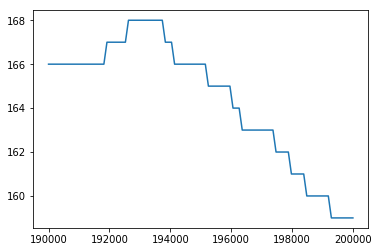

Best number of clicks: 168.0
Best base bid: 192626.262626


192626.26262626261

In [21]:
base_bid_optimization(190000, 200000, 100, valid_pred, valid_y)

In [22]:
bids = 192626.262626*valid_pred
_, c, _, _, _, _, _ = new_performance(bids, valid_y)

               CTR: (0.1307)%
        num_clicks: 168
             spend: 6195121 (99.12)%
              aCPM: 20.3837163774
              aCPC: 36.8757202381
num_in_budget_wins: 128582
 ads_within_budget: 303925


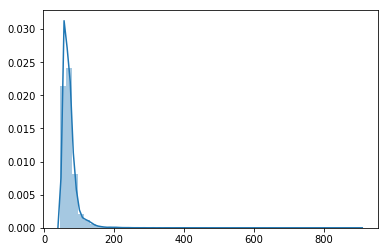

In [239]:
import seaborn as sns 
sns.distplot(example_x)
plt.show()

In [240]:
np.median(example_x)

67.260487365571564

### ORTB Strategy

In [76]:
lmda = 0.020564283951632803
c_val = np.linspace(0.1, 1000, 100)
clicks = np.zeros(shape=(c_val.shape[0]))

for i, cv in zip(range(100), c_val):
    bids = ortb_bidding_strategy(valid_pred*10000, cv, lmda, 2)
    _, c, _, _, _, _, _ = new_performance(bids, valid_y, verbose=False)
    clicks[i] = c


In [24]:
6250/303925

0.020564283951632803

In [77]:
cvi = clicks.argmax()

In [78]:
cvi

2

In [80]:
##### EXAMPLES OF ORTB BIDDING STRATEGY #####
print("ORTB test:-")
print("---------------------------------")
example_x = ortb_bidding_strategy(valid_pred*100000, c_val[cvi], lmda, 2)
new_performance(example_x, valid_y)

ORTB test:-
---------------------------------
               CTR: (0.0717)%
        num_clicks: 112
             spend: 6249937 (100.00)%
              aCPM: 23.3660848141
              aCPC: 55.8030089286
num_in_budget_wins: 156191
 ads_within_budget: 267479


(0.07170707659212118,
 112,
 6249937,
 23.36608481413494,
 55.80300892857143,
 156191,
 267479)

In [92]:
bid_pay = [[a,b] for a, b in zip(example_x, valid_y.payprice)]

In [51]:
np.median(valid_pred)

0.00032617259

In [52]:
np.mean(valid_pred)

0.00071288284

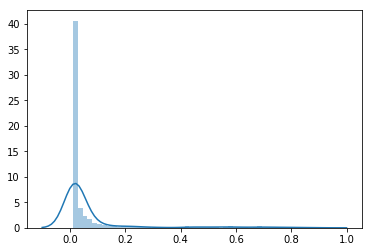

In [72]:
import seaborn as sns
sns.distplot(valid_pred[valid_pred>0.01])
plt.show()

In [93]:
bid_pay

[[54.43961865193932, 23],
 [49.61701115759351, 75],
 [54.399686787810857, 65],
 [57.707279254674944, 6],
 [50.666799795406767, 5],
 [80.855800075902721, 22],
 [78.43616195419682, 31],
 [76.088239982400083, 20],
 [72.690879864777699, 58],
 [40.261419842271401, 55],
 [81.650069923159478, 88],
 [55.386721279608039, 55],
 [48.262019875896449, 49],
 [85.300333110130794, 110],
 [79.571219180369553, 160],
 [47.819533116286401, 16],
 [70.308634657630463, 50],
 [66.464851466019113, 76],
 [73.303035034072465, 89],
 [72.02489938581283, 136],
 [58.896230077661464, 55],
 [85.529168383139989, 50],
 [73.725713936207086, 64],
 [54.479063831879039, 129],
 [81.112618944280442, 20],
 [60.756512776967433, 166],
 [49.635628585375599, 88],
 [88.980114927408238, 221],
 [75.856575324347361, 69],
 [104.69548024198525, 70],
 [56.721064791072664, 20],
 [63.414335720670095, 18],
 [65.35749466430552, 114],
 [79.47945089970186, 33],
 [85.453770069614677, 126],
 [67.474392883182759, 66],
 [83.516799898933371, 133],


In [224]:
lmda = np.linspace(5e-7, 1, 100)
c_val = np.linspace(0.1, 100, 100)
clicks = np.zeros(shape=(lmda.shape[0], c_val.shape[0]))

for i, lm in zip(range(len(lmda)), lmda):
    for j, cv in zip(range(len(c_val)), c_val):
        bids = ortb_bidding_strategy(valid_pred*100000, cv, lm, 2)
        _, c, _, _, _, _, _ = new_performance(bids, valid_y, verbose=False)
        clicks[i, j] = c


In [225]:
lmi, cvi = np.unravel_index(clicks.argmax(), clicks.shape)

In [226]:
lmda[lmi]

0.010101505050505052

In [227]:
c_val[cvi]

9.1818181818181817

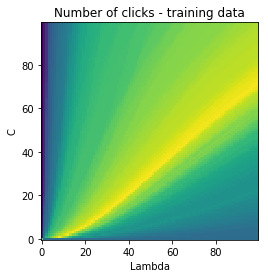

In [111]:
fig = plt.figure(figsize=plt.figaspect(0.25))

ax = fig.add_subplot(1, 1, 1)
ax.set_title("Number of clicks - training data")
ax.set_xlabel("Lambda")
ax.set_ylabel("C")
#plt.xticks
plt.imshow(clicks, cmap='viridis', origin='lower')
plt.MaxNLocator(100)
plt.show()

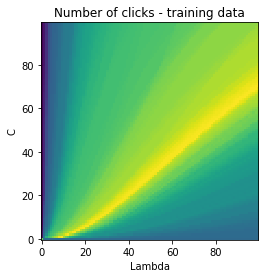

In [238]:
fig = plt.figure(figsize=plt.figaspect(0.25))

ax = fig.add_subplot(1, 1, 1)
ax.set_title("Number of clicks - training data")
ax.set_xlabel("Lambda")
ax.set_ylabel("C")
#plt.xticks
plt.imshow(clicks, cmap='viridis', origin='lower')
plt.MaxNLocator(100)
plt.show()

In [237]:
##### EXAMPLES OF ORTB BIDDING STRATEGY #####
print("ORTB test:-")
print("---------------------------------")
example_x = ortb_bidding_strategy(valid_pred*100000, c_val[cvi], lmda[lmi], 2)
new_performance(example_x, valid_y)

ORTB test:-
---------------------------------
               CTR: (0.0909)%
        num_clicks: 146
             spend: 6243967 (99.90)%
              aCPM: 20.5444336596
              aCPC: 42.7668972603
num_in_budget_wins: 160568
 ads_within_budget: 303925


(0.090927208410143998,
 146,
 6243967,
 20.544433659619973,
 42.766897260273971,
 160568,
 303925)

In [180]:
##### EXAMPLES OF ORTB BIDDING STRATEGY #####
print("ORTB test:-")
print("---------------------------------")
example_x = ortb_bidding_strategy(valid_pred*100000, 133.388889, 7.777779e-01, 2)
new_performance(example_x, valid_y)

ORTB test:-
---------------------------------
               CTR: (0.0792)%
        num_clicks: 113
             spend: 6249932 (100.00)%
              aCPM: 27.890400689
              aCPC: 55.3091327434
num_in_budget_wins: 142765
 ads_within_budget: 224089


(0.079151052428816593,
 113,
 6249932,
 27.890400689011955,
 55.309132743362831,
 142765,
 224089)

In [113]:
##### EXAMPLES OF ORTB BIDDING STRATEGY #####
print("ORTB test:-")
print("---------------------------------")
example_x = ortb_bidding_strategy(train_pred*100000, c_val[cvi], lmda[lmi], 2)
new_performance(example_x, train_y)

ORTB test:-
---------------------------------
               CTR: (0.1130)%
        num_clicks: 182
             spend: 6249935 (100.00)%
              aCPM: 20.6589616202
              aCPC: 34.3403021978
num_in_budget_wins: 161074
 ads_within_budget: 302529


(0.11299154425916037,
 182,
 6249935,
 20.658961620208309,
 34.340302197802202,
 161074,
 302529)

In [198]:
plt.plot(range(len(example_x)), np.array(example_x/np.softmax(example_x)))
plt.show()

AttributeError: module 'numpy' has no attribute 'softmax'

### Save Model

In [23]:
import pickle as pkl
pkl_filename = '../lynray_xgbbest.pkl'
with open(pkl_filename, 'wb') as file:  
    pkl.dump(xgb_model, file)

In [ ]:
### Prepare Submission

In [24]:
submission = pd.read_csv('../Data/Group_xx.csv')

In [25]:
submission.head()

,bidid,bidprice
0,366c563de7d90feb9d4dab53e795a93fb3157387,0.0
1,29167d4caa719788b5a342dbaa25151d53121f80,0.0
2,ff8bc3f4d44a3ea60c5f3a3a8fbe7cd98fb2966e,0.0
3,844c2da00d45315f20b748ec131c26ee99a7cbc7,0.0
4,c6017f0ad0c44d7d0c9b62583ea863f28941c0ca,0.0


In [26]:
test_predictions = 192626.262626*xgb_model.predict(test_X_encoded)

In [27]:
submission.bidprice = test_predictions

In [28]:
submission.head()

,bidid,bidprice
0,366c563de7d90feb9d4dab53e795a93fb3157387,179.634781
1,29167d4caa719788b5a342dbaa25151d53121f80,467.404449
2,ff8bc3f4d44a3ea60c5f3a3a8fbe7cd98fb2966e,17.213163
3,844c2da00d45315f20b748ec131c26ee99a7cbc7,56.284248
4,c6017f0ad0c44d7d0c9b62583ea863f28941c0ca,75.971619


In [29]:
submission.to_csv('../Group_01_xgbbb.csv')

### Extra

In [73]:
def plot_budget_graph(bids, true_y, budget=6250*1000):
        #--- Combine data in to one dataframe ------
    data = true_y.copy()
    data['bid'] = bids
    
    #--- Work out which bids were successful ---
    #> if they are greater than payprice
    won_bid = data.payprice <= data.bid 
    
    #--- Only keep bids that are within budget -
    success_bids_csum = np.cumsum(np.array(data.payprice) * won_bid)

    #--- prior budget check 
    prior_success_bids_csum = ([0] + list(success_bids_csum))[:len(success_bids_csum)]
    new_budget = np.repeat(budget, len(success_bids_csum)) - prior_success_bids_csum
    
    #--- in budget 
    in_budget_bids = (success_bids_csum <= np.repeat(budget, len(success_bids_csum))) & (np.array(data.bid) <= new_budget)
    in_budget_wins = won_bid & in_budget_bids
    
    spend_csum = success_bids_csum*in_budget_bids
    plt.plot(spend_csum[:spend_csum.argmax()+1])
    plt.show()
    
    return 

In [96]:
spend = plot_budget_graph(example_x, valid_y)

NameError: name 'plot_budget_graph' is not defined

In [81]:
def join_table(data, newData, rowLen, colLen):
    for col in newData.keys():
        data = data.join(pd.DataFrame({col: [newData[col][r, c] for r in range(rowLen) for c in range(colLen)]}).reset_index(drop=True))
    return data

In [82]:
def analysis_table(pred, y, params, t, budget=6250*1000):
    start = time.time()
    lmda_range = params[0]
    c_val_range = params[1]
    clicks = np.zeros(shape=(lmda.shape[0], c_val.shape[0]))
    CTR = np.zeros(shape=(lmda.shape[0], c_val.shape[0]))
    spend = np.zeros(shape=(lmda.shape[0], c_val.shape[0]))
    CPM = np.zeros(shape=(lmda.shape[0], c_val.shape[0]))
    eCPC = np.zeros(shape=(lmda.shape[0], c_val.shape[0]))
    winrate_a = np.zeros(shape=(lmda.shape[0], c_val.shape[0]))
    budget_lifetime = np.zeros(shape=(lmda.shape[0], c_val.shape[0]))
    
    params = {'lamda': [lmda_range[l] for l in range(len(lmda_range)) for _ in range(len(c_val_range))],
              'c' : [c_val_range[c] for _ in range(len(lmda_range)) for c in range(len(c_val_range))]}
    vals = pd.DataFrame(params).reset_index(drop=True)

    for i, lm in zip(range(len(lmda_range)), lmda_range):
        for j, cv in zip(range(len(c_val_range)), c_val_range):
            bids = ortb_bidding_strategy(pred, cv, lm, t)
            CTR[i,j], clicks[i, j], s, CPM[i, j], eCPC[i, j], wins, imps  = new_performance(bids, y, budget=budget, verbose=False)
            spend[i,j] = 100*s/budget
            winrate_a[i,j] = wins*100/imps
            budget_lifetime[i,j]= imps*100/len(y)
    cols = {'CTR': CTR,
            'clicks': clicks,
            'spend%': spend,
            'aCPM': CPM,
            'eCPC': eCPC,
            'win%': winrate_a,
            'lifetime%': budget_lifetime}
    vals = join_table(vals, cols, len(lmda_range), len(c_val_range))

    print("time spent:- {0:.2f} seconds".format(time.time()-start))
    return vals, clicks

In [86]:
lmda = np.linspace(5e-7, 2.5, 100)
c_val = np.linspace(10, 1010, 100)

In [87]:
a,c = analysis_table(valid_pred*100000, valid_y, [lmda, c_val], 1)

time spent:- 831.23 seconds


In [88]:
a.sort_values(by='clicks', ascending=False)

,c,lamda,lifetime%,win%,CTR,spend%,clicks,eCPC,aCPM
933,343.333333,2.272732e-01,100.000000,43.366620,0.125946,98.895744,166.0,37.234843,20.337202
927,282.727273,2.272732e-01,100.000000,42.875051,0.127390,96.640896,166.0,36.385880,19.873508
936,373.636364,2.272732e-01,100.000000,43.574895,0.125345,99.868240,166.0,37.600994,20.537188
935,363.535354,2.272732e-01,100.000000,43.501193,0.125557,99.527792,166.0,37.472813,20.467178
934,353.434343,2.272732e-01,100.000000,43.436703,0.125743,99.235088,166.0,37.362608,20.406985
932,333.232323,2.272732e-01,100.000000,43.291273,0.126166,98.549696,166.0,37.104554,20.266039
931,323.131313,2.272732e-01,100.000000,43.224809,0.126360,98.239360,166.0,36.987711,20.202221
930,313.030303,2.272732e-01,100.000000,43.143868,0.126597,97.896288,166.0,36.858542,20.131671
929,302.929293,2.272732e-01,100.000000,43.063914,0.126832,97.535696,166.0,36.722777,20.057517
928,292.828283,2.272732e-01,100.000000,42.973760,0.127098,97.103472,166.0,36.560042,19.968634


In [148]:
np.max(np.array(a.groupby(['c'])['clicks'].max()))

127.0

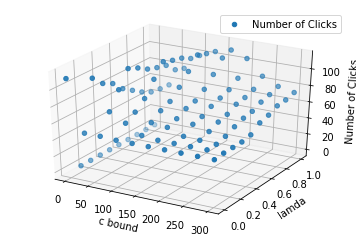

In [173]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
mpl.rcParams['legend.fontsize'] = 10
new_table = a[a['clicks'] > 0]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(a['c'], a['lamda'], a['clicks'], label='Number of Clicks')
ax.set_xlabel('c')
ax.set_ylabel('lamda')
ax.set_zlabel('Number of Clicks')
ax.legend()

plt.show()

In [241]:
lynray_bids = example_x.copy()

In [246]:
lynray_bids[lynray_bids >150] = 150

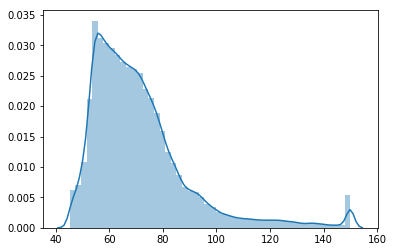

In [248]:
import seaborn as sns 
sns.distplot(lynray_bids)
plt.show()

In [249]:
new_performance(example_x, valid_y)

               CTR: (0.0909)%
        num_clicks: 146
             spend: 6243967 (99.90)%
              aCPM: 20.5444336596
              aCPC: 42.7668972603
num_in_budget_wins: 160568
 ads_within_budget: 303925


(0.090927208410143998,
 146,
 6243967,
 20.544433659619973,
 42.766897260273971,
 160568,
 303925)